# Chapter 13. Adventures in covariance

In [68]:
import numpy as np
import pandas as pd
import pymc3 as pm
from pymc3.glm import GLM
import arviz as az
import rethinking
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import theano as tt

In [3]:
plt.rcParams["figure.figsize"] = (20, 10)

In [48]:
df = pd.read_csv("../external/rethinking/data/chimpanzees.csv", sep=";")
print(f"Data contains {len(df)} samples")
df.head()

Data contains 504 samples


,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


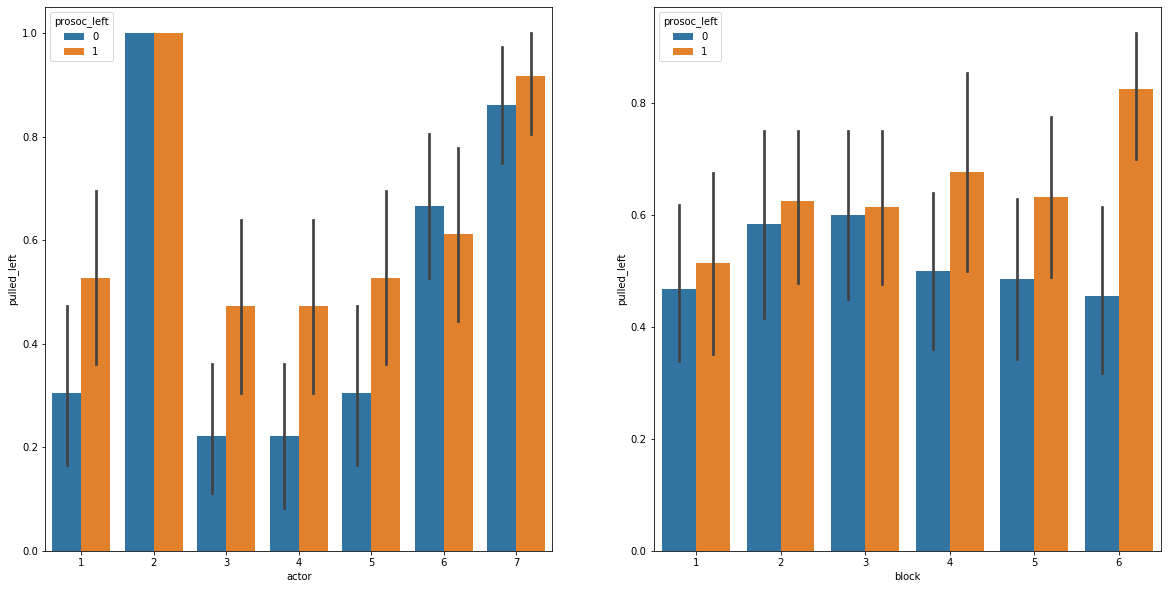

In [52]:
_, ax = plt.subplots(1, 2)
sns.barplot(x="actor", y="pulled_left", hue="prosoc_left", data=df, ax=ax[0]);
sns.barplot(x="block", y="pulled_left", hue="prosoc_left", data=df, ax=ax[1]);

In [65]:
models = {}
traces = {}

In [75]:
# The code produces a warning that is likely related to this open issue for Theano:
# https://github.com/Theano/Theano/issues/6667

actor = df.actor.values - 1
block = df.block.values - 1
condition = df.condition.values
prosoc_left = df.prosoc_left.values
pulled_left = df.pulled_left.values
n_actors = len(set(actor))
n_blocks = len(set(block))

with pm.Model() as model:
    σ_actor = pm.HalfCauchy.dist(beta=2.5)
    σ_block = pm.HalfCauchy.dist(beta=2.5)
    Σ_actor_ = pm.LKJCholeskyCov("Σ_actor", n=3, eta=1, sd_dist=σ_actor)
    Σ_block_ = pm.LKJCholeskyCov("Σ_block", n=3, eta=1, sd_dist=σ_block)
    Σ_actor = pm.expand_packed_triangular(3, Σ_actor_, lower=True)
    Σ_block = pm.expand_packed_triangular(3, Σ_block_, lower=True)
    α_actor = pm.MvNormal("α_actor", mu=np.zeros(3), chol=Σ_actor, shape=(n_actors, 3))
    α_block = pm.MvNormal("α_block", mu=np.zeros(3), chol=Σ_block, shape=(n_blocks, 3))
    α0 = pm.Normal("α0", 0, 1)
    α1 = pm.Normal("α1", 0, 1)
    α2 = pm.Normal("α2", 0, 1)
    A = α0 + α_actor[actor, 0] + α_block[block, 0]
    B = α1 + α_actor[actor, 1] + α_block[block, 1]
    C = α2 + α_actor[actor, 2] + α_block[block, 2]
    p = pm.math.invlogit(A + (B + C * condition) * prosoc_left)
    pm.Binomial("y", 1, p, observed=pulled_left)
models[0] = model

# This model samples much faster than the previous one
with pm.Model() as model:
    σ_actor = pm.HalfCauchy.dist(beta=2.5)
    σ_block = pm.HalfCauchy.dist(beta=2.5)
    Σ_actor_ = pm.LKJCholeskyCov("Σ_actor", n=3, eta=1, sd_dist=σ_actor)
    Σ_block_ = pm.LKJCholeskyCov("Σ_block", n=3, eta=1, sd_dist=σ_block)
    Σ_actor = pm.expand_packed_triangular(3, Σ_actor_, lower=True)
    Σ_block = pm.expand_packed_triangular(3, Σ_block_, lower=True)
    z_actor = pm.Normal("z_actor", mu=0, sigma=1, shape=(n_actors, 3))
    z_block = pm.Normal("z_block", mu=0, sigma=1, shape=(n_blocks, 3))
    α_actor = pm.Deterministic("α_actor", tt.dot(Σ_actor, z_actor.T).T)
    α_block = pm.Deterministic("α_block", tt.dot(Σ_block, z_block.T).T)
    α0 = pm.Normal("α0", 0, 1)
    α1 = pm.Normal("α1", 0, 1)
    α2 = pm.Normal("α2", 0, 1)
    A = α0 + α_actor[actor, 0] + α_block[block, 0]
    B = α1 + α_actor[actor, 1] + α_block[block, 1]
    C = α2 + α_actor[actor, 2] + α_block[block, 2]
    p = pm.math.invlogit(A + (B + C * condition) * prosoc_left)
    pm.Binomial("y", 1, p, observed=pulled_left)
models[1] = model

In [77]:
for (key, model) in models.items():
    if key not in traces:
        traces[key] = pm.sample(model=model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α2, α1, α0, z_block, z_actor, Σ_block, Σ_actor]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:57<00:00, 69.89draws/s] 
/home/bart/.pyenv/versions/anaconda3-5.3.1/envs/statistical-rethinking/lib/python3.8/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/bart/.pyenv/versions/anaconda3-5.3.1/envs/statistical-rethinking/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpre

In [83]:
s = az.summary(traces[1])
pd.set_option("display.max_rows", len(s) + 1)
display(s)

/home/bart/.pyenv/versions/anaconda3-5.3.1/envs/statistical-rethinking/lib/python3.8/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/bart/.pyenv/versions/anaconda3-5.3.1/envs/statistical-rethinking/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"z_actor[0,0]",-0.450,0.338,-1.086,0.147,0.016,0.011,438.0,438.0,434.0,794.0,1.01
"z_actor[0,1]",0.042,0.853,-1.564,1.625,0.027,0.022,1029.0,754.0,1036.0,908.0,1.00
"z_actor[0,2]",0.086,0.886,-1.609,1.625,0.026,0.021,1119.0,858.0,1154.0,399.0,1.01
"z_actor[1,0]",1.932,0.619,0.863,3.163,0.022,0.016,781.0,781.0,771.0,999.0,1.00
"z_actor[1,1]",0.108,0.999,-1.754,2.056,0.023,0.026,1821.0,749.0,1792.0,1183.0,1.00
"z_actor[1,2]",0.058,0.994,-1.900,1.848,0.023,0.027,1882.0,669.0,1864.0,1129.0,1.00
"z_actor[2,0]",-0.585,0.354,-1.283,0.017,0.016,0.012,468.0,468.0,471.0,791.0,1.00
"z_actor[2,1]",0.399,0.876,-1.163,2.041,0.032,0.022,770.0,761.0,766.0,1137.0,1.00
"z_actor[2,2]",-0.209,0.976,-2.085,1.639,0.045,0.040,474.0,299.0,643.0,193.0,1.01
"z_actor[3,0]",-0.595,0.361,-1.318,0.005,0.017,0.012,445.0,445.0,432.0,733.0,1.01
